## Time Series Forecasting Workshop, Sep 2022

*NUS MSBA 2022, Sept 17th*

*By Shivam Bansal*

---


### Run this Notebook

**Option1:**

- Preferred for Mac / Linux Users. 

- Directly in your Laptop: This notebook can be run directly in your laptop, but need to ensure that required packages are installed. 

**Option2:**

- Run in Google Collab. (Better Option for Windows Users)

- Follow this link: https://colab.research.google.com/ and upload this notebook. 


### Install All Packages 




In [2]:
#### Uncomment the following line to install all the required packages used in this notebook ####

# !pip3 install matplotlib pandas numpy seaborn statsmodels sklearn xgboost scipy pmdarima prophet

### 1. Import the Required Packages

In [3]:
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt 
from pandas import Series
import seaborn as sns 
import pandas as pd 
import numpy as np

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb


### 2. Load Dataset and PreProcessing

In [4]:
df = pd.read_csv("data/passengers.csv")
print ("df Shape: ", df.shape)
print ("df Sample:")
df.head()

df Shape:  (144, 2)
df Sample:


,date,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


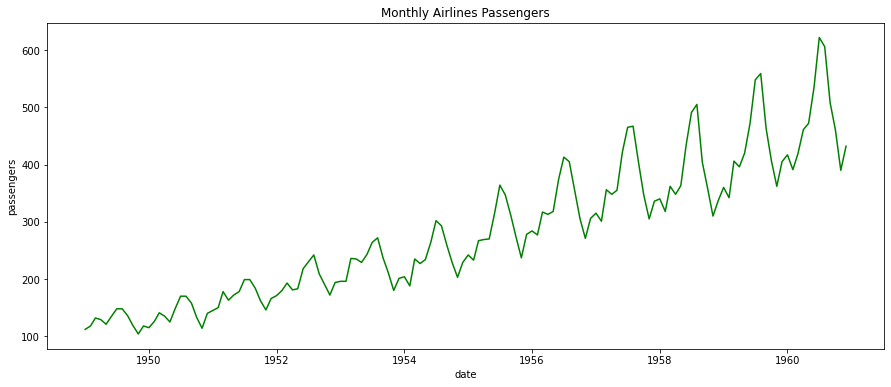

Training Set Shape:  (108, 2)
Test Set Shape:  (36, 2)


In [5]:
## 2.1 Define date column and target column 
date_column = 'date'
target_column = 'passengers'

## 2.2 Convert date_column into proper datetime format 
df[date_column] = pd.to_datetime(df[date_column])

## 2.3 Visualize the dataset 
def line_chart(x_col, y_col, df, title = ""):
    plt.figure(figsize=(15, 6))
    plt.title(title);
    sns.lineplot(x = x_col, y = y_col, data = df, color = 'green')
    plt.show();

line_chart(x_col = date_column, 
           y_col = target_column, 
           df = df, 
           title = "Monthly Airlines Passengers")

## 2.4 Split the dataset - Training and Test Set
train_df, test_df = df[:108], df[108:]
print ("Training Set Shape: ", train_df.shape)
print ("Test Set Shape: ", test_df.shape)

<AxesSubplot:title={'center':'Cubic Fill'}, xlabel='date'>

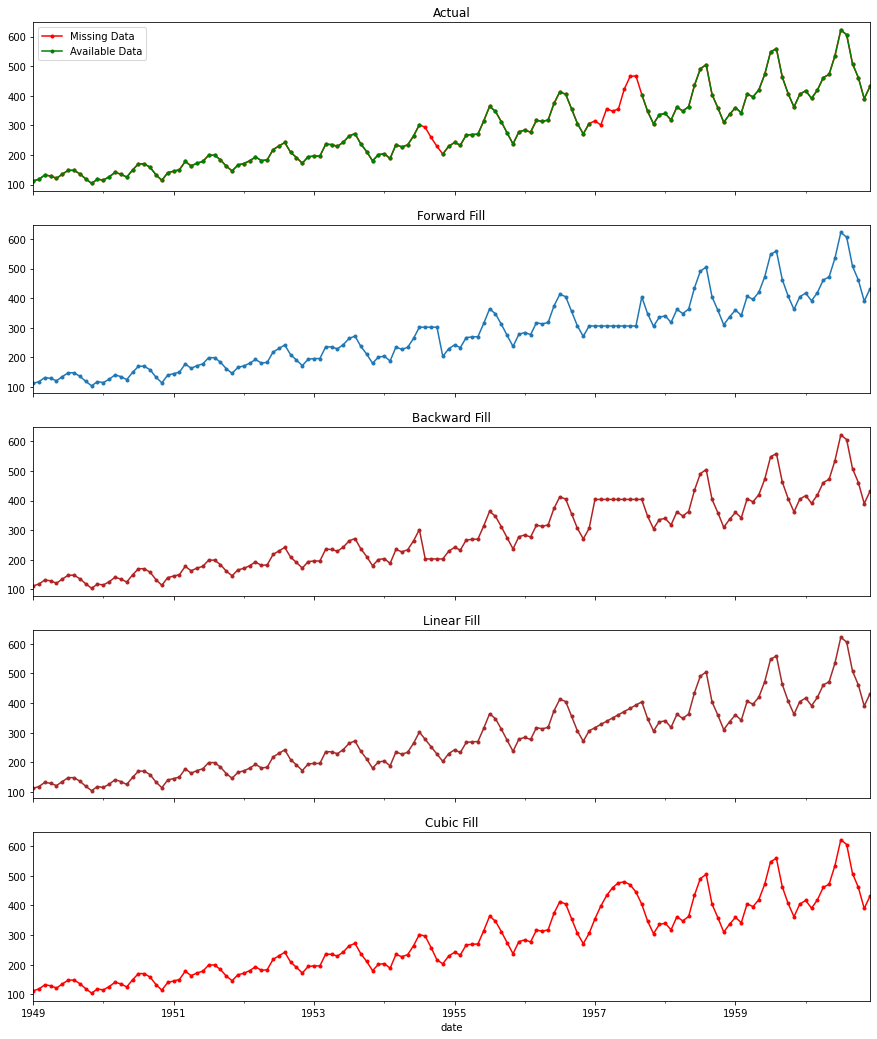

In [6]:
## 2.5 Missing Values - Detection and Imputation Techniques 

df_o = df.copy(deep = True)
df_o = df_o.set_index(date_column, inplace = False)

df_m = pd.read_csv('data/passengers_with_missing.csv')
df_m[date_column] = pd.to_datetime(df_m[date_column], infer_datetime_format = True)
df_m = df_m.set_index(date_column, inplace = False)

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(15, 18))
plt.rcParams.update({'xtick.bottom' : False})

## 1. Actual 
df_o.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df_m.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

## 2. Forward Fill 
df_ffill = df_m.ffill()
df_ffill[target_column].plot(title='Forward Fill', ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill 
df_bfill = df_m.bfill()
df_bfill[target_column].plot(title="Backward Fill", ax=axes[2], label='Backward Fill', color='firebrick', style=".-")

## 4. Linear Interpolation 
df_m['row_num'] = np.arange(df_o.shape[0])
df_nona = df_m.dropna(subset = [target_column])
f = interp1d(df_nona['row_num'], df_nona[target_column])
df_m['linear_fill'] = f(df_m['row_num'])
df_m['linear_fill'].plot(title="Linear Fill", ax=axes[3], label='Cubic Fill', color='brown', style=".-")

## 5. Cubic Interpolation 
f2 = interp1d(df_nona['row_num'], df_nona[target_column], kind='cubic')
df_m['cubic_fill'] = f2(df_m['row_num'])
df_m['cubic_fill'].plot(title="Cubic Fill", ax=axes[4], label='Cubic Fill', color='red', style=".-")

### 3. Decomposition - Time Series Components 

Additive: 
y(t) = Level + Trend + Seasonality + Noise

Multiplicative: 
y(t) = Level * Trend * Seasonality * Noise

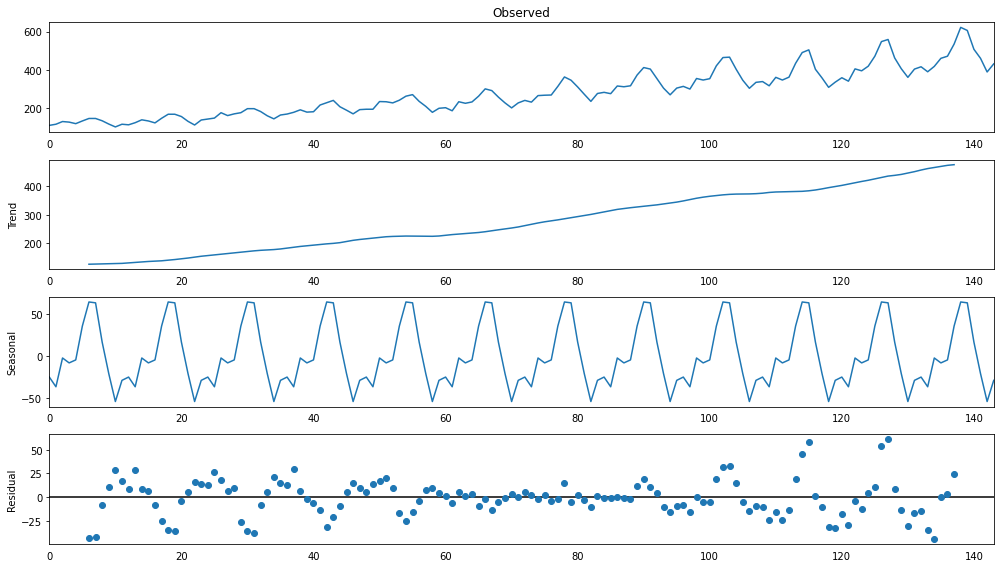

In [7]:
series = list(df[target_column])
result = seasonal_decompose(series, model='additive', period=12)

fig = result.plot()
fig.set_size_inches((14, 8))
fig.tight_layout()
plt.show()

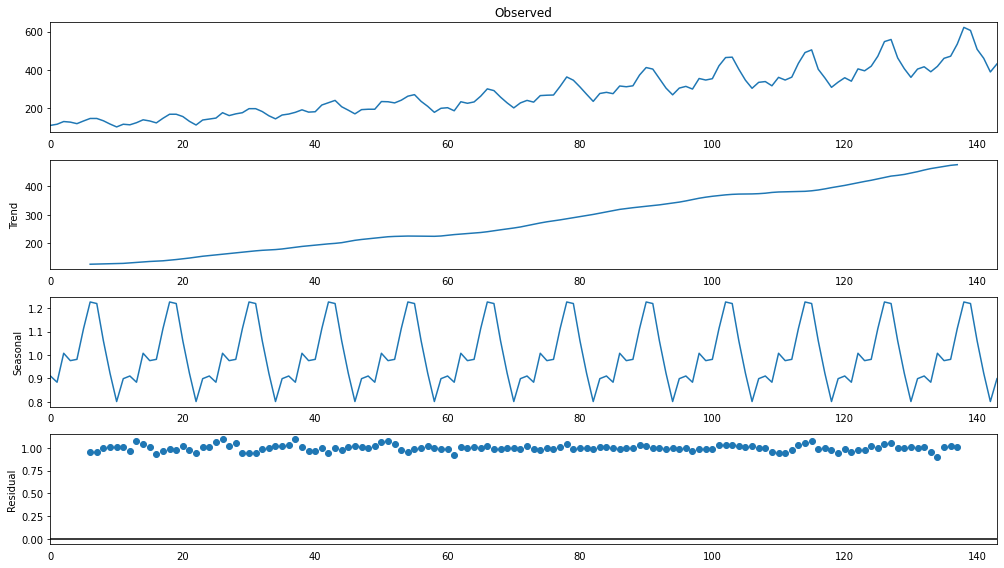

In [8]:
series = list(df[target_column])
result = seasonal_decompose(series, model='multiplicative', period=12)

fig = result.plot()
fig.set_size_inches((14, 8))
fig.tight_layout()
plt.show()

### 4. Model - Time Series Forecasting 

### 4.1 Model1: Simple Moving Average 

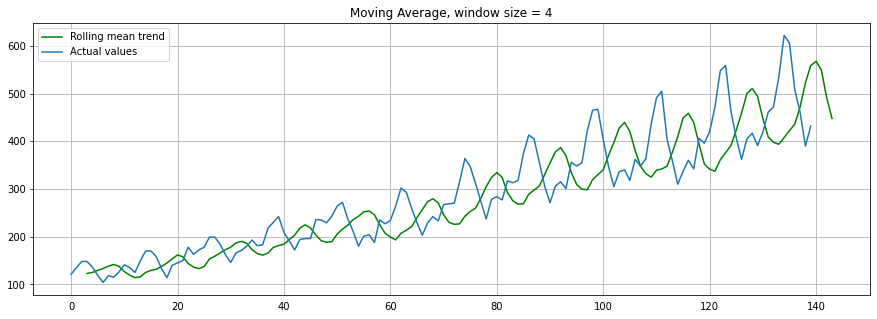

In [9]:
window = 4 # 8
rolling_mean = df[target_column].rolling(window=window).mean()

plt.figure(figsize=(15,5))
plt.title("Moving Average, window size = " + str(window))
plt.plot(rolling_mean, "g", label="Rolling mean trend")
plt.plot(series[window:], label="Actual values")
plt.legend(loc="upper left")
plt.grid(True)

In [10]:
## Prediction at T = Mean (t-1, t-2, t-3, ... t-n)

mean_val = 0
for i in range(window):
    mean_val += df[target_column].iloc(0)[108-i] 
    
print (mean_val / window)

332.0


### 4.2 Model2: Simple Exponential Smoothing

Weighted averages - Recent observation has more weight than past observations. 

Exponential smoothing forecasting methods are similar in that a prediction is a weighted sum of past observations, but the model explicitly uses an exponentially decreasing weight for past observations.


smoothing parameter: α
- When α = 0, the forecasts are equal to the average of the historical data 
- When α = 1, the forecasts will be equal to the value of the last observation

Large values mean that the model pays attention mainly to the most recent past observations, whereas smaller values mean more of the history is taken into account when making a prediction.

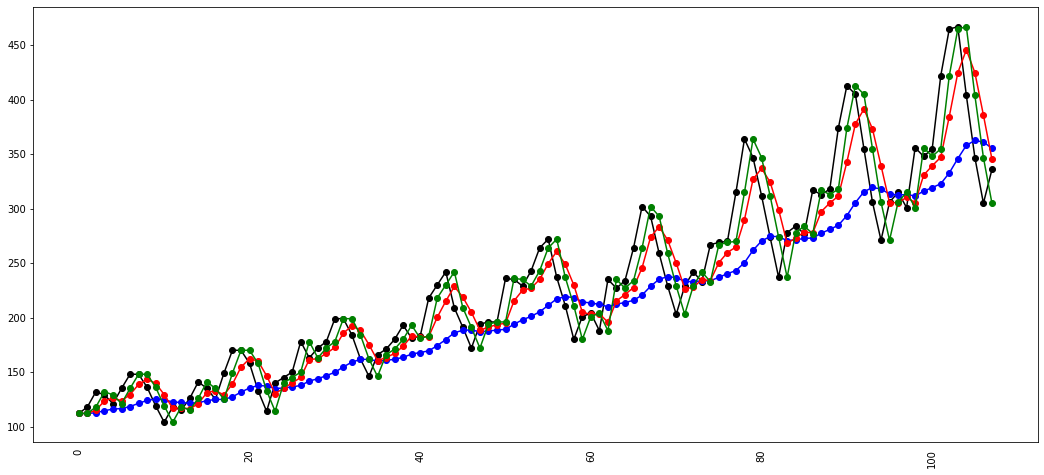

In [11]:
plt.figure(figsize=(18, 8))
plt.plot(train_df[target_column], marker='o', color="black")

fit1 = SimpleExpSmoothing(train_df[target_column]).fit(smoothing_level=0.1, optimized=False)
plt.plot(fit1.fittedvalues, marker="o", color="b")

fit2 = SimpleExpSmoothing(train_df[target_column]).fit(smoothing_level=0.5, optimized=False)
plt.plot(fit2.fittedvalues, marker="o", color="r")

fit3 = SimpleExpSmoothing(train_df[target_column]).fit(smoothing_level=1, optimized=False)
plt.plot(fit3.fittedvalues, marker="o", color="g")

plt.xticks(rotation="vertical")
plt.show()

In [12]:
fit1.predict()    

108    353.575616
dtype: float64

### Model3: 4.3 Holt Linear

Expanding the SES method, the Holt method helps you forecast time series data that has a trend. In addition to the level smoothing parameter α introduced with the SES method, the Holt method adds the trend smoothing parameter β*. Like with parameter α, the range of β* is also between 0 and 1.

/var/folders/zs/01htfcyn49vdy32cvpnyyg580000gn/T/ipykernel_1525/629089020.py:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit1 = ExponentialSmoothing(train_df[target_column]).fit(smoothing_level=0.1, smoothing_slope=0.1, optimized=False)
/var/folders/zs/01htfcyn49vdy32cvpnyyg580000gn/T/ipykernel_1525/629089020.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit2 = ExponentialSmoothing(train_df[target_column]).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)
/var/folders/zs/01htfcyn49vdy32cvpnyyg580000gn/T/ipykernel_1525/629089020.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit3 = ExponentialSmoothing(train_df[target_column]).fit(smoothing_level=1, smoothing_slope=0.1, optimized=False)


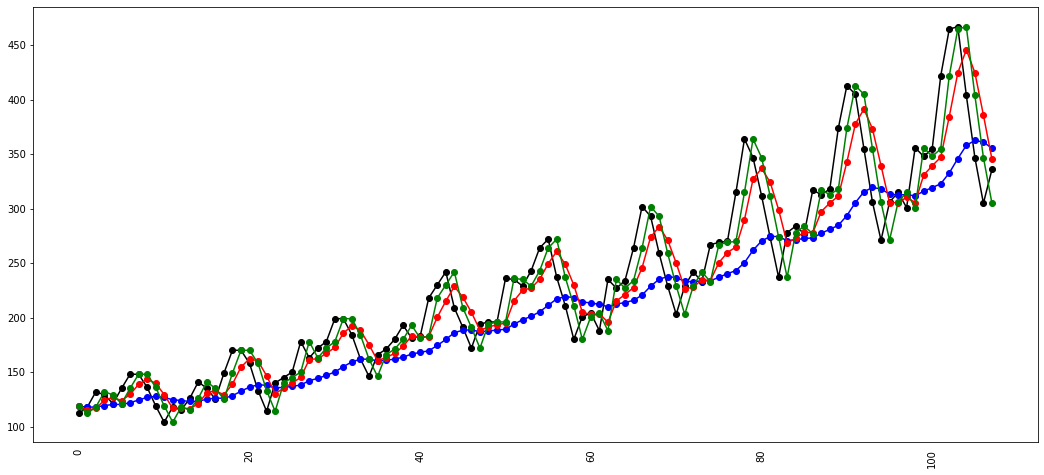

In [13]:
plt.figure(figsize=(18, 8))
plt.plot(train_df[target_column], marker='o', color="black")

fit1 = ExponentialSmoothing(train_df[target_column]).fit(smoothing_level=0.1, smoothing_slope=0.1, optimized=False)
plt.plot(fit1.fittedvalues, marker="o", color="b")

fit2 = ExponentialSmoothing(train_df[target_column]).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)
plt.plot(fit2.fittedvalues, marker="o", color="r")

fit3 = ExponentialSmoothing(train_df[target_column]).fit(smoothing_level=1, smoothing_slope=0.1, optimized=False)
plt.plot(fit3.fittedvalues, marker="o", color="g")

plt.xticks(rotation="vertical")
plt.show()

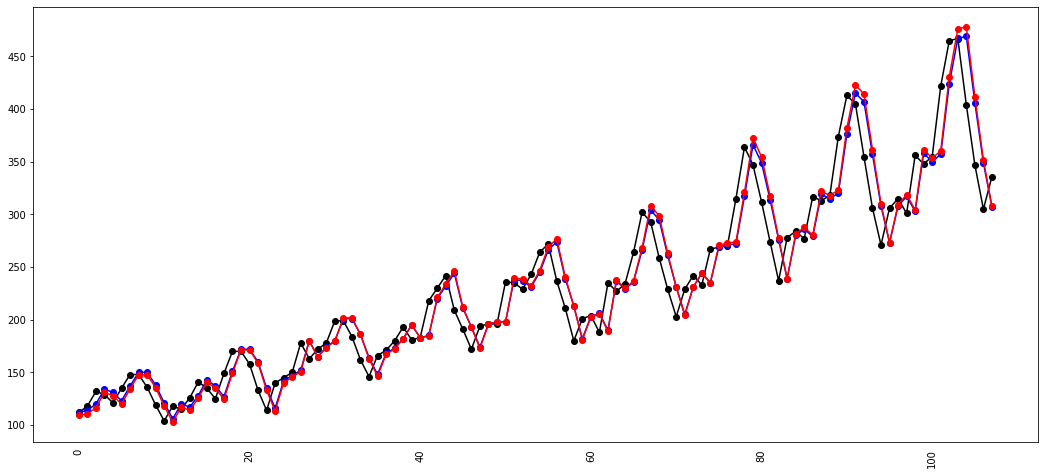

In [14]:
fit1 = Holt(train_df[target_column]).fit()  
fit2 = Holt(train_df[target_column], exponential=True).fit() 

plt.figure(figsize=(18, 8))
plt.plot(train_df[target_column], marker='o', color='black')
plt.plot(fit1.fittedvalues, marker='o', color='b')
plt.plot(fit2.fittedvalues, marker='o', color='r')
plt.xticks(rotation="vertical")
plt.show()

In [15]:
fit1.predict()    

108    338.060774
dtype: float64

### Model4: 4.4 Holt Winter with Seasonal Effect

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=36 and a Box-Cox transformation 50.65
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=36 and a Box-Cox transformation 62.31


/var/folders/zs/01htfcyn49vdy32cvpnyyg580000gn/T/ipykernel_1525/1542182869.py:12: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit()


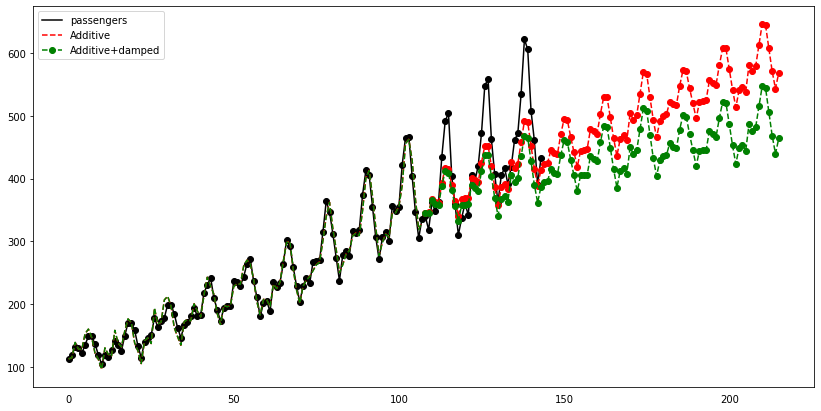

In [16]:
def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit()
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit()
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit()
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit()
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

y = df[target_column]
train_y = train_df[target_column]
test_y = test_df[target_column]
predict_date = len(y) - len(test_y)
    
holt_win_sea(y, train_y, test_y,'additive', 36, predict_date)


The Root Mean Squared Error of additive trend, multiplicative seasonal of period season_length=36 and a Box-Cox transformation 26.63


/var/folders/zs/01htfcyn49vdy32cvpnyyg580000gn/T/ipykernel_1525/1542182869.py:30: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit()
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


The Root Mean Squared Error of additive damped trend, multiplicative seasonal of period season_length=36 and a Box-Cox transformation 26.63


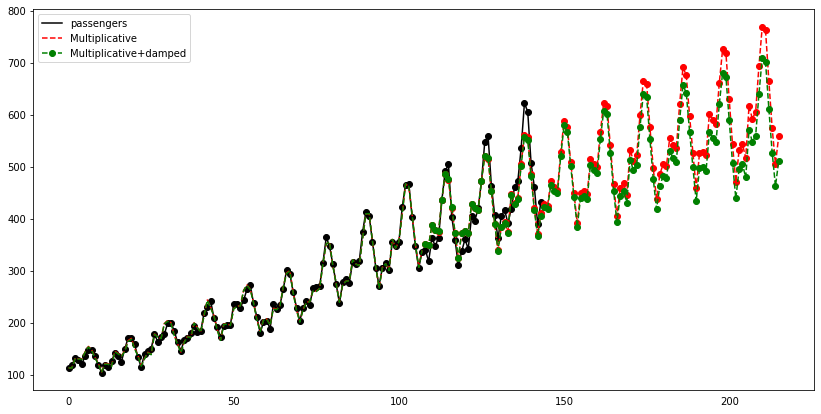

In [17]:
holt_win_sea(y, train_y, test_y,'multiplicative', 36, predict_date)

### Model #5: ARIMA 

Auto Regressive Integrated with Moving Average 

---

- AR(p) Autoregression – a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series

- I(d) Integration – uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times

- MA(q) Moving Average – a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model

---

- p is the order of the AR term
- q is the order of the MA term
- d is the differencing steps required to make the time series stationary


In [18]:
from statsmodels.tsa.arima.model import ARIMA

model4 = ARIMA(train_df[target_column].values, order=(1, 1, 1))
model4 = model4.fit()
print(model4.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  108
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -490.640
Date:                Sun, 11 Sep 2022   AIC                            987.280
Time:                        14:23:36   BIC                            995.299
Sample:                             0   HQIC                           990.531
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4856      0.136     -3.567      0.000      -0.752      -0.219
ma.L1          0.8760      0.078     11.289      0.000       0.724       1.028
sigma2       559.5788     94.858      5.899      0.0

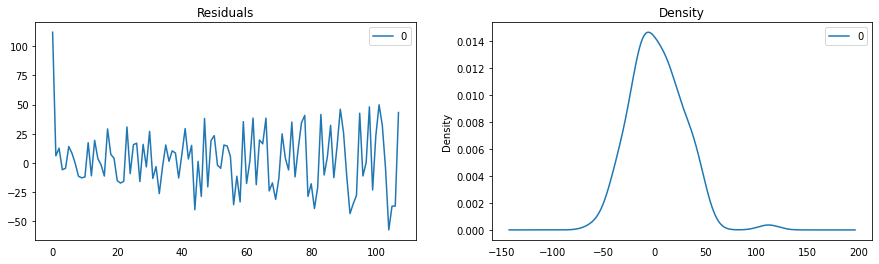

In [19]:
residuals = pd.DataFrame(model4.resid)
fig, ax = plt.subplots(1,2, figsize=(15, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Auto ARIMA

In [20]:
import pmdarima as pm

model4_1 = pm.auto_arima(train_df[target_column].values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model4_1.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1005.552, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1497.737, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1002.849, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1004.260, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1003.923, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1003.632, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1000.566, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1002.262, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1006.850, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1001.514, Time=0

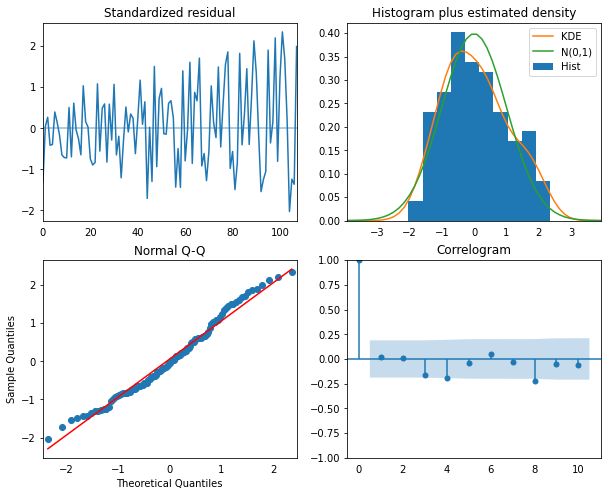

In [21]:
model4_1.plot_diagnostics(figsize=(10,8))
plt.show()

In [22]:
model4_2 = ARIMA(train_df[target_column].values, order=(1,2,2))
model4_2 = model4_2.fit()
print(model4.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  108
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -490.640
Date:                Sun, 11 Sep 2022   AIC                            987.280
Time:                        14:23:39   BIC                            995.299
Sample:                             0   HQIC                           990.531
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4856      0.136     -3.567      0.000      -0.752      -0.219
ma.L1          0.8760      0.078     11.289      0.000       0.724       1.028
sigma2       559.5788     94.858      5.899      0.0

In [23]:
## Make Next Forecasts 

start = len(train_df)
end  = len(train_df) + len(test_df) -1

test_pred = model4_2.predict(start=start, end=end, dynamic=False, typ="levels")
test_df['pred'] = test_pred

/var/folders/zs/01htfcyn49vdy32cvpnyyg580000gn/T/ipykernel_1525/2439020462.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = test_pred


ARIMA Model Test MAE: 54.958


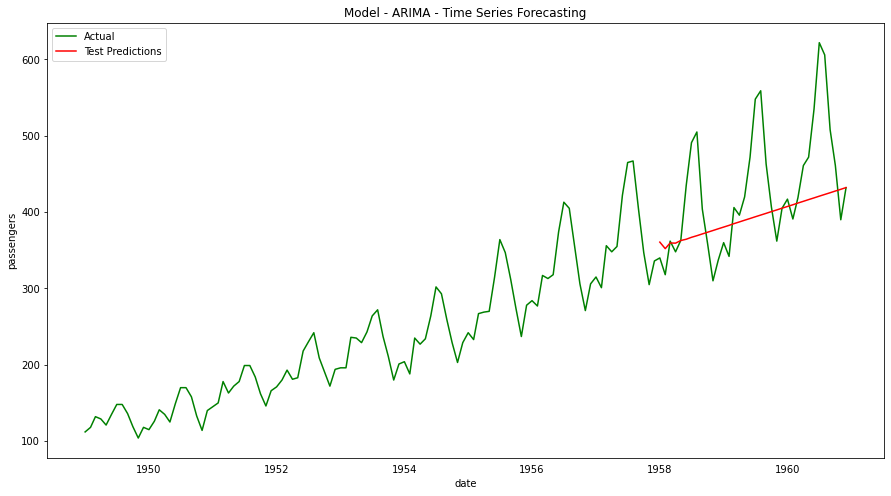

In [24]:
mae = mean_absolute_error(test_df[target_column], test_df["pred"])
print('ARIMA Model Test MAE: %.3f' % mae)

plt.figure(figsize=(15, 8))
plt.title("Model - ARIMA - Time Series Forecasting");
sns.lineplot(x = date_column, y = target_column, data = df, color = 'green', label='Actual')
sns.lineplot(x = date_column, y = 'pred', data = test_df, color = 'red', label = 'Test Predictions')
plt.show();

### Model #6: Facebook Prophet

1. Open Source time series forecasting model developed by Facebook
2. Based on an Additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 
3. Works best with time series that have strong seasonal effects and several seasons of historical data
4. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
5. Mainly built for univariate time series models . though there are extensions avialable 


14:23:40 - cmdstanpy - INFO - Chain [1] start processing
14:23:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Train MAE: 11.892
Prophet Model Test MAE: 40.129


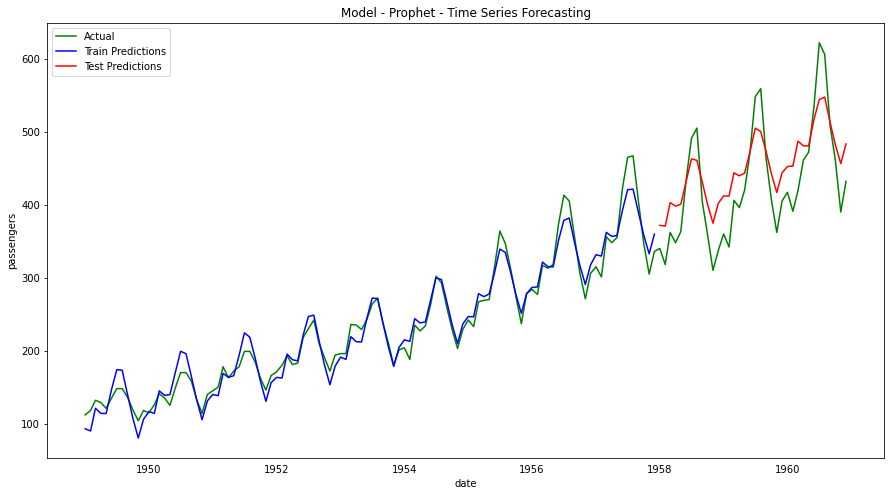

In [25]:
from prophet import Prophet
pd.options.mode.chained_assignment = None

## fit the prophet model 
model5 = Prophet()
model5.fit(train_df[[date_column, target_column]].rename(columns={date_column: "ds", target_column: "y"}))

## predict on train 
forecast = model5.predict(train_df[[date_column, target_column]].rename(columns={date_column: "ds"}))
train_pred = forecast.yhat.values
train_df['pred'] = train_pred

## predict on test
forecast = model5.predict(test_df[[date_column, target_column]].rename(columns={date_column: "ds"}))
test_pred = forecast.yhat.values
test_df['pred'] = test_pred

## Evaluate Model Performance 
mae = mean_absolute_error(train_df[target_column], train_df["pred"])
print('Prophet Model Train MAE: %.3f' % mae)

mae = mean_absolute_error(test_df[target_column], test_df["pred"])
print('Prophet Model Test MAE: %.3f' % mae)

plt.figure(figsize=(15, 8))
plt.title("Model - Prophet - Time Series Forecasting");
sns.lineplot(x = date_column, y = target_column, data = df, color = 'green', label='Actual')
sns.lineplot(x = date_column, y = 'pred', data = train_df, color = 'blue', label='Train Predictions')
sns.lineplot(x = date_column, y = 'pred', data = test_df, color = 'red', label = 'Test Predictions')
plt.show();

### Model #7: Machine Learning Approach 

Time Series forecasting problems can be structured as a machine learning (regression) task by adding elements / features of time series. 

In [27]:
energy_hourly = pd.read_csv('data/energy_consumption.csv', index_col=[0], parse_dates=[0])

energy_hourly.sort_index(inplace=True)

def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

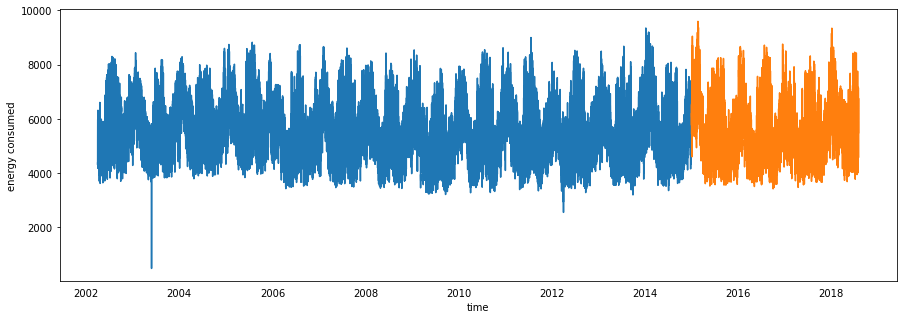

In [28]:
train, test = split_data(energy_hourly, '01-Jan-2015')

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(train.index, train['PJMW_MW'])
plt.plot(test.index, test['PJMW_MW'])
plt.show()

In [29]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [30]:
X_train, y_train = create_features(train), train['PJMW_MW']
X_test, y_test   = create_features(test), test['PJMW_MW']

X_train.shape, y_train.shape

/var/folders/zs/01htfcyn49vdy32cvpnyyg580000gn/T/ipykernel_1525/1055516352.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
/var/folders/zs/01htfcyn49vdy32cvpnyyg580000gn/T/ipykernel_1525/1055516352.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


((111767, 8), (111767,))

In [31]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [32]:
X_test_pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, X_test_pred)
print('ARIMA Model Test MAE: %.3f' % mae)

ARIMA Model Test MAE: 489.663


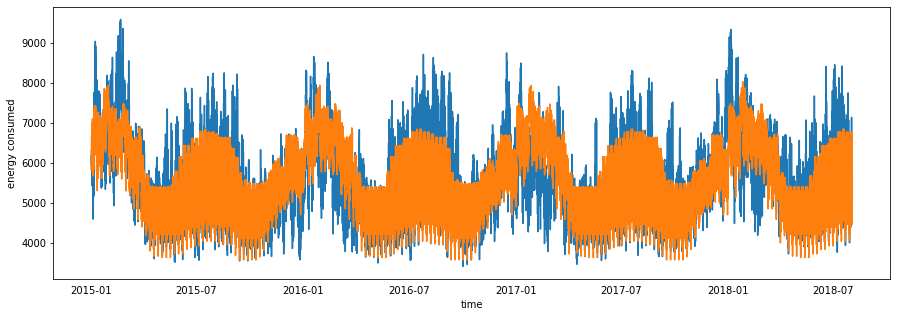

In [33]:
plt.figure(figsize = (15, 5))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(y_test.index, y_test)
plt.plot(X_test.index, X_test_pred)
plt.show()

## Thank You 

Reach out - Shivam Bansal (shivam.bansal@h2o.ai)